<a href="https://colab.research.google.com/github/konan108/ERC-Rebalancing/blob/main/erc_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🔄 Google Sheets → Colab → Google Sheets: ERC (Equal Risk Contribution)

Pipeline
1) Preise aus Google Sheets lesen (Format: Date, Ticker1, …).
2) Monats-Logreturns (5 Jahre Fenster, Month-End).
3) Kovarianz Σ bauen (symmetrisieren + Ridge), dann ERC (long-only).
4) Gewichte schreiben: SleeveWeight, TotalPortfolioWeight (=Sleeve*25%), RC_%.
5) Optional: RC%-Balken & lokaler CSV-Export.

In [67]:
# --- Install (Colab) ---
%pip -q install gspread pandas numpy scipy

# --- Imports (sauber, zentral) ---
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from typing import Tuple
from datetime import datetime
import matplotlib.pyplot as plt

In [68]:

# --- CONFIG ---
# Google Sheets: Spreadsheet und Tabnamen
SPREADSHEET_NAME = "ERC Rebalancing"        # <- anpassen
PRICES_SHEET_NAME = "Prices_5Y"             # <- Tab mit Preisen (Date + Ticker-Spalten)
OUTPUT_SHEET_NAME = "Weights"               # <- Tab für Output (wird erstellt, falls nicht vorhanden)

# Datenformat Preise-Tab:
# - Spalte A: Date (YYYY-MM-DD oder DD.MM.YYYY etc.)
# - Spalten B..: Ticker (adjusted close, monatliche Preise möglich; sonst werden sie auf month-end resampled)

# Frequenz + Fenster
RETURN_FREQ = "monthly"    # "monthly" empfohlen
WINDOW_MONTHS = 60         # 5 Jahre

# ERC-Constraints (Total-Portfolio)
SLEEVE_SHARE = 0.25 # Satellitenanteil am Gesamtportfolio (25%)

# Numerik
RIDGE = 1e-10
N_STARTS = 32
SEED = 2025


In [69]:

# --- AUTH & Access to Google Sheets ---
from google.colab import auth
import gspread

auth.authenticate_user()
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

# Open or create output sheet
ss = gc.open(SPREADSHEET_NAME)
try:
    prices_ws = ss.worksheet(PRICES_SHEET_NAME)
except Exception as e:
    raise RuntimeError(f"Prices-Tab '{PRICES_SHEET_NAME}' nicht gefunden in Spreadsheet '{SPREADSHEET_NAME}'.") from e

# Ensure OUTPUT sheet exists
try:
    weights_ws = ss.worksheet(OUTPUT_SHEET_NAME)
except Exception:
    weights_ws = ss.add_worksheet(title=OUTPUT_SHEET_NAME, rows=100, cols=10)


In [70]:

# --- Read Prices from Google Sheets ---
raw = prices_ws.get_all_values()
if not raw or len(raw) < 2:
    raise ValueError("Prices-Tab scheint leer zu sein oder hat keine Datenzeilen.")

hdr = raw[0]
rows = raw[1:]

df = pd.DataFrame(rows, columns=hdr)

# Date parsing (robust)
date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True, infer_datetime_format=True)
df = df.dropna(subset=[date_col])
df = df.set_index(date_col).sort_index()

# Convert numeric (detect German commas)
for c in df.columns:
    # Replace comma decimal if present
    ser = df[c].astype(str).str.replace(',', '.', regex=False)
    df[c] = pd.to_numeric(ser, errors='coerce')

# Drop columns fully NaN; forward-fill occasional gaps; drop any remaining NaN rows
df = df.dropna(how="all", axis=1).ffill().dropna(how="any")
print("Loaded prices shape:", df.shape)
df.tail()


Loaded prices shape: (61, 6)


/tmp/ipython-input-352220957.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True, infer_datetime_format=True)


,ABEC.DEX,ASML.AMS,IUI1.FRK,KEE.FRK,RMS.PAR,SU.PAR
Date,,,,,,
2025-05-30,150.3084,652.1704,487.45,365.3644,2428.0,221.35
2025-06-30,150.6844,675.8077,460.40,343.9310,2299.0,225.80
2025-07-31,169.1079,613.1000,422.50,322.3979,2151.0,228.25
2025-08-29,181.6965,636.6000,402.85,326.2859,2091.0,210.05
2025-09-30,211.9000,828.1000,379.75,315.0000,2083.0,237.60


In [71]:
# --- Returns (monthly log returns, last 5y) ---
def compute_returns(prices: pd.DataFrame, freq: str = "monthly") -> pd.DataFrame:
    if freq == "monthly":
        px = prices.resample("ME").last()
    elif freq == "daily":
        px = prices
    else:
        raise ValueError("freq must be 'daily' or 'monthly'")

    # Sicherheitsnetz
    if (px <= 0).any().any():
        bad_rows = int((px <= 0).any(axis=1).sum())
        raise ValueError(f"Preise enthalten nicht-positive Werte (Problem-Zeilen: {bad_rows}).")

    rets = np.log(px).diff().dropna(how="any")
    rets.index.name = "Date"
    return rets

# ⬇️ DIESE ZEILE FEHLTE
rets_all = compute_returns(df, RETURN_FREQ)

# Window schneiden
rets = rets_all.iloc[-WINDOW_MONTHS:].copy() if len(rets_all) > WINDOW_MONTHS else rets_all.copy()


# Sanity checks / Info
assert rets.index.is_monotonic_increasing, "Index nicht monoton steigend."
assert len(rets) >= min(48, WINDOW_MONTHS//2), f"Zu wenige Monatszeilen: {len(rets)}"
print("Returns shape (windowed):", rets.shape)
print("Zeitraum:", rets.index.min(), "→", rets.index.max())
rets.tail()

Returns shape (windowed): (60, 6)
Zeitraum: 2020-10-31 00:00:00 → 2025-09-30 00:00:00


,ABEC.DEX,ASML.AMS,IUI1.FRK,KEE.FRK,RMS.PAR,SU.PAR
Date,,,,,,
2025-05-31,0.069126,0.115625,0.072965,-0.002180,0.024575,0.098446
2025-06-30,0.002498,0.035603,-0.057092,-0.060454,-0.054594,0.019904
2025-07-31,0.115349,-0.097381,-0.085906,-0.064655,-0.066541,0.010792
2025-08-31,0.071801,0.037613,-0.047625,0.011987,-0.028290,-0.083096
2025-09-30,0.153777,0.262992,-0.059051,-0.035201,-0.003833,0.123243


In [72]:
# --- Covariance (Hilfsfunktion) ---
def build_cov(rets: pd.DataFrame, ridge: float = 1e-10) -> Tuple[np.ndarray, list[str]]:
    Sigma_df = rets.cov()  # Sample-Kovarianz
    # Symmetrisieren + kleiner Ridge für Numerik-Stabilität
    S = 0.5 * (Sigma_df.values + Sigma_df.values.T) + np.eye(Sigma_df.shape[0]) * ridge
    tickers = list(Sigma_df.columns)
    return S, tickers

# Nutzung
S, tickers = build_cov(rets, RIDGE)
n = len(tickers)
print("Tickers:", tickers)

# Sanity-Check
if not np.isfinite(S).all():
    raise ValueError("Kovarianzmatrix enthält NaN/Inf.")

cond = np.linalg.cond(S)
if cond > 1e10:
    print(f"Warnung: Σ schlecht konditioniert (cond≈{cond:.2e}). RIDGE erhöhen?")


Tickers: ['ABEC.DEX', 'ASML.AMS', 'IUI1.FRK', 'KEE.FRK', 'RMS.PAR', 'SU.PAR']


In [73]:
# --- ERC (pure long-only) ----------------------------------------------------
def total_variance(w: np.ndarray, S: np.ndarray) -> float:
    return float(w.T @ S @ w)

def risk_contributions(w: np.ndarray, S: np.ndarray) -> np.ndarray:
    # RC_i = w_i * (Σ w)_i
    return w * (S @ w)

def erc_objective(w: np.ndarray, S: np.ndarray) -> float:
    rc = risk_contributions(w, S)
    tv = total_variance(w, S)
    target = tv / len(w)
    return float(np.sum((rc - target) ** 2))

def _project_feasible(x: np.ndarray, lo: np.ndarray, hi: np.ndarray) -> np.ndarray:
    # In Bounds clippen, dann Summe→1 sanft Richtung Bounds-Mittelpunkt
    x = np.clip(x, lo, hi)
    for _ in range(12):
        s = x.sum()
        if abs(s - 1.0) < 1e-12:
            break
        mid = (lo + hi) / 2.0
        x = np.clip(x + 0.5 * (mid - x) * (1.0 - s), lo, hi)
    return x

def erc_solve(
    S: np.ndarray,
    bounds: list[tuple[float, float]] | None = None,
    n_starts: int = N_STARTS,
    seed: int = SEED,
    ftol: float = 1e-16,
    maxiter: int = 20_000,
) -> Tuple[np.ndarray, float]:
    n = S.shape[0]
    if bounds is None:
        bounds = [(0.0, 1.0)] * n  # long-only

    lo = np.array([b[0] for b in bounds], dtype=float)
    hi = np.array([b[1] for b in bounds], dtype=float)
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    rng = np.random.default_rng(seed)

    best_fun = np.inf
    best_x = None
    for _ in range(n_starts):
        x0 = rng.random(n); x0 /= x0.sum()
        x0 = _project_feasible(x0, lo, hi)
        res = minimize(
            erc_objective, x0, args=(S,), method="SLSQP",
            bounds=bounds, constraints=cons,
            options={'ftol': ftol, 'maxiter': maxiter}
        )
        if res.success and res.fun < best_fun:
            best_fun = float(res.fun)
            best_x = res.x

    if best_x is None:
        raise RuntimeError("ERC-Optimierung: keine Konvergenz.")

    w = np.clip(best_x, lo, hi)
    w /= w.sum()
    return w, best_fun

# --- Solve (pure ERC, nur long-only bounds) ---------------------------------
bounds = [(0.0, 1.0) for _ in range(n)]
w_sleeve, obj = erc_solve(S, bounds=bounds)

rc_abs = risk_contributions(w_sleeve, S)
rc_pct = rc_abs / rc_abs.sum()
w_total = SLEEVE_SHARE * w_sleeve

target = 1/len(w_sleeve)
max_dev = float(np.max(np.abs(rc_pct - target)))

# --- Diagnose + Qualitätscheck ---------------------------------------------
def erc_diagnostics(w: np.ndarray, S: np.ndarray, idx) -> None:
    rc = risk_contributions(w, S); rc_pct = rc / rc.sum()
    target = 1 / len(w)
    print("Anzahl Ticker:", len(w))
    print("Summe w:", float(w.sum()))
    print("min/max w:", float(w.min()), float(w.max()))
    print("RC% Ziel 1/n =", target)
    print("Max. Abweichung RC%:", float(np.abs(rc_pct - target).max()))
    print("Ø Abweichung RC%:", float(np.abs(rc_pct - target).mean()))
    print("Fensterlänge (Monate):", len(idx))
    print("Zeitspanne:", idx.min(), "→", idx.max())
    print(f"Objective: {obj:.3e}")
    print(f"Max RC%-Abw: {max_dev:.3e}")

erc_diagnostics(w_sleeve, S, rets.index)
target = 1/len(w_sleeve)
max_dev = float(np.max(np.abs(rc_pct - target)))
assert max_dev < 1e-4, f"ERC nicht sauber konvergiert (Max RC%-Abw = {max_dev:.6g})"

# --- Output-DataFrame -------------------------------------------------------
out = pd.DataFrame({
    "Ticker": tickers,
    "SleeveWeight": w_sleeve,
    "TotalPortfolioWeight": w_total,
    "RC_%": rc_pct
}).sort_values("SleeveWeight", ascending=False).reset_index(drop=True)

# Sauber runden für Output
out = out.round({"SleeveWeight": 8, "TotalPortfolioWeight": 8, "RC_%": 8})

Anzahl Ticker: 6
Summe w: 1.0
min/max w: 0.12375349926656441 0.2054501662039956
RC% Ziel 1/n = 0.16666666666666666
Max. Abweichung RC%: 1.8096289322588888e-07
Ø Abweichung RC%: 6.911494273194781e-08
Fensterlänge (Monate): 60
Zeitspanne: 2020-10-31 00:00:00 → 2025-09-30 00:00:00


/tmp/ipython-input-3498044503.py:140: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  performance_ws.update("A1", perf_values)


Wrote performance to 'Performance'.


In [74]:

# --- Write back to Google Sheets (Output tab) ---
# We overwrite from A1 downward with a fresh table
hdr = list(out.columns)
values = [hdr] + out.round(8).values.tolist()

# Clear and update
weights_ws.clear()
weights_ws.update('A1', values)

print(f"Wrote {len(out)} rows to '{OUTPUT_SHEET_NAME}' in '{SPREADSHEET_NAME}'.")


/tmp/ipython-input-1021681524.py:8: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  weights_ws.update('A1', values)


Wrote 6 rows to 'Weights' in 'ERC Rebalancing'.


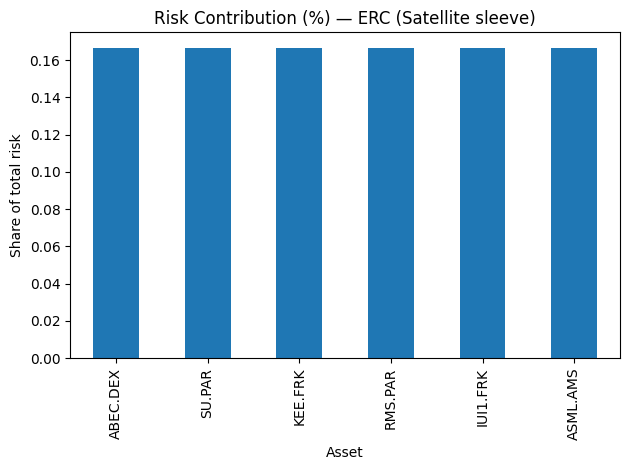

In [75]:

# --- Plot RC% ---
fig, ax = plt.subplots()
out.set_index("Ticker")["RC_%"].plot(kind="bar", ax=ax)
ax.set_title("Risk Contribution (%) — ERC (Satellite sleeve)")
ax.set_ylabel("Share of total risk")
ax.set_xlabel("Asset")
fig.tight_layout()
plt.show()
plt.close(fig)


In [76]:

# --- Save CSV locally (optional download) ---
csv_path = "/content/erc_weights_out.csv"
out.to_csv(csv_path, index=False)
print("Also saved locally at:", csv_path)


Also saved locally at: /content/erc_weights_out.csv
